In [56]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [57]:
!ls track

driving_log.csv  IMG


In [58]:
!pip3 install imgaug

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [60]:
datadir = 'track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [61]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


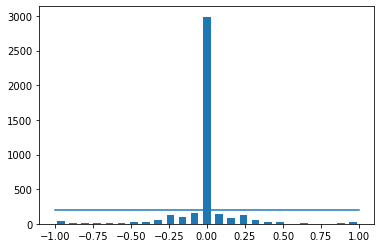

In [62]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5       # centers steering origin at 0
print(center)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4053
removed: 2790
remaining: 1263


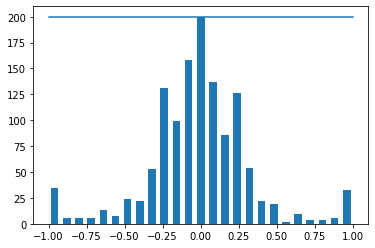

In [63]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)         # adds steering angle if it belongs to a bin
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]     # returns a specific row from the df
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [65]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_val)))

Training Samples: 1010
Valid Samples: 253


Text(0.5, 1.0, 'Validation set')

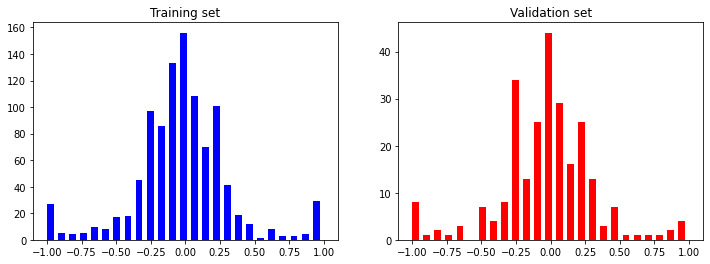

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axs[0].set_title('Training set')
axs[1].hist(y_val, bins=num_bins, width=0.05, color='red')
axs[1].set_title('Validation set')

In [0]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))       # range of 1 - 1.3
    image = zoom.augment_image(image)
    return image

Text(0.5, 1.0, 'Zoomed Image')

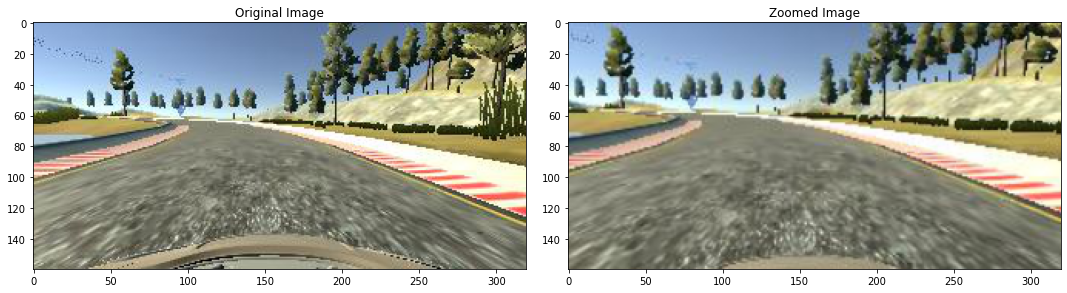

In [68]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y":(-0.1, 0.1)})       # set range of translation between -10% - +10%
    image = pan.augment_image(image)
    return image

Text(0.5, 1.0, 'Panned Image')

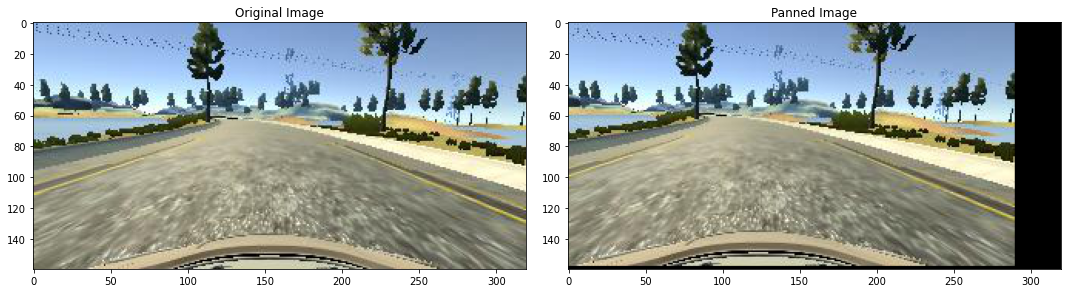

In [70]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
    brightness= iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness Altered Image')

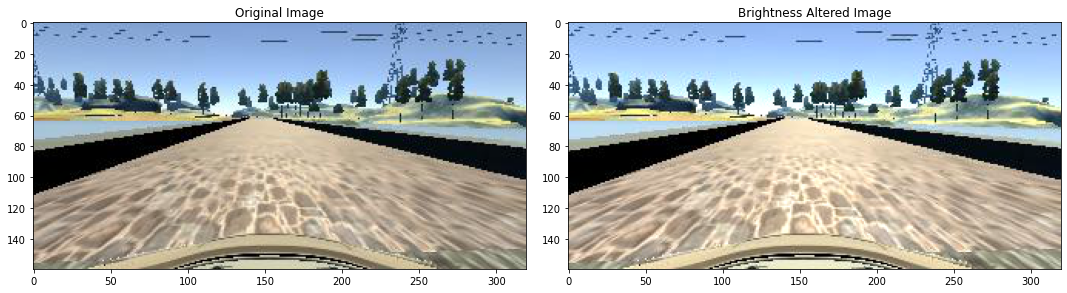

In [72]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)      # 0 for vertical, 1 for horizontal, -1 for combination of both
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped ImageSteering Angle: 0.2')

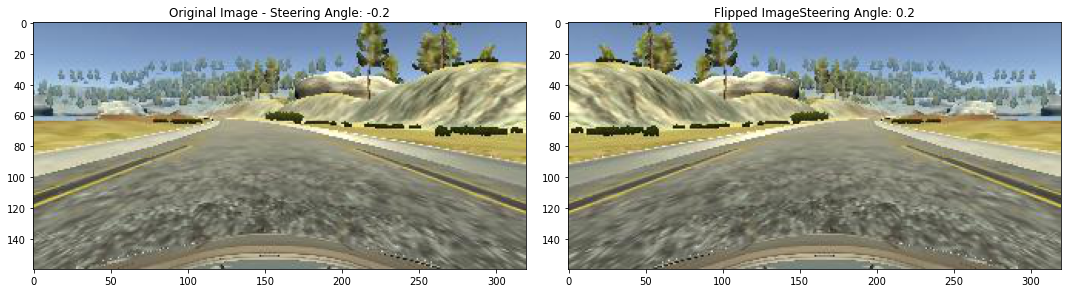

In [74]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle: ' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image' + 'Steering Angle: ' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:          # runs 50% of the time
        image = pan(image)
    if np.random.rand() < 0.5:          # runs 50% of the time
        image = zoom(image)
    if np.random.rand() < 0.5:          # runs 50% of the time
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:          # runs 50% of the time
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

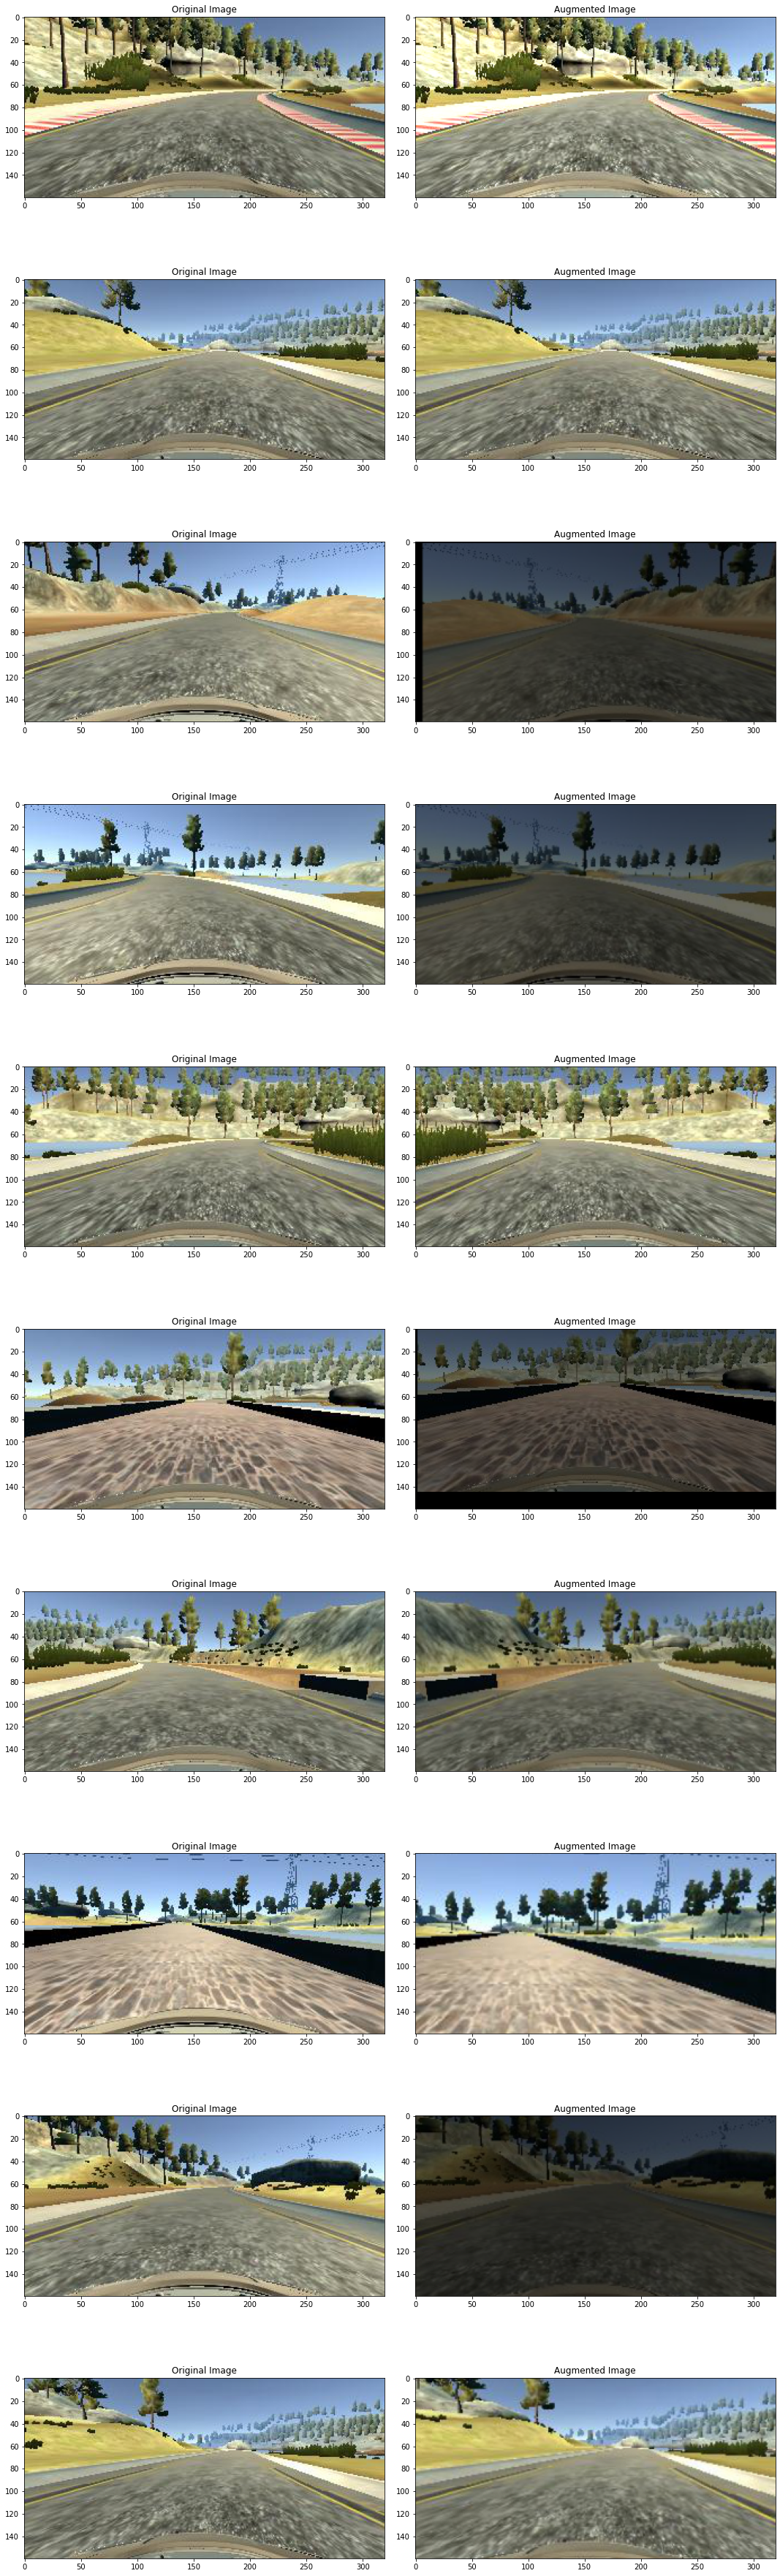

In [76]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, augmented_steering_angle = random_augment(random_image, random_steering)
    axs[i][0].imshow(original_image)
    axs[i][0].set_title('Original Image')
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('Augmented Image')

In [0]:
def img_preprocess(img):
    # img = mpimg.imread(image)
    img = img[60:135,:, :]            # crop height of image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)      # NVIDIA recommends images in the YUV format for NVIDIA models
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))   # resize for better training
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

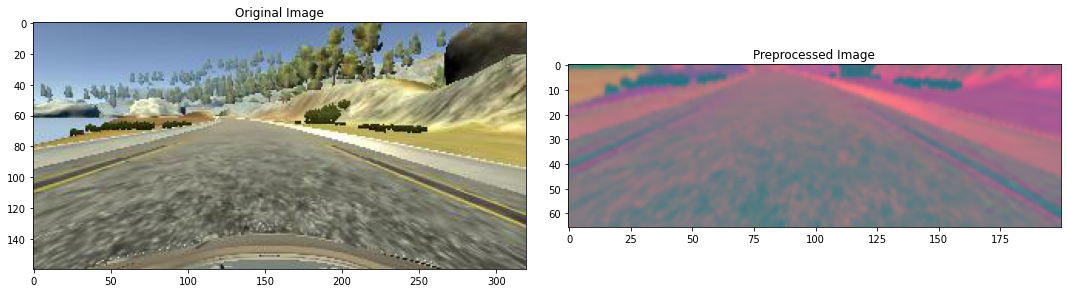

In [90]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_val = np.array(list(map(img_preprocess, X_val)))
# plt.imshow(X_train[random.randint(0, len(X_train)-1)])
# plt.axis('off')
# print(X_train.shape)
# shape: (num_samples, height, width, channels)

In [0]:
def batch_generator(image_paths, steering_angles, batch_size, isTraining):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if isTraining: 
                im, steering = random_augment(image_paths[random_index], steering_angles[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_angles[random_index]
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

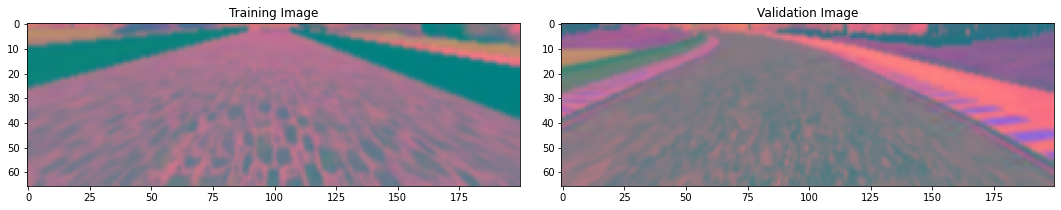

In [89]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_val_gen, y_val_gen = next(batch_generator(X_val, y_val, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(X_val_gen[0])
axs[1].set_title('Validation Image')

In [0]:
def nvidia_model():
    model = Sequential()

    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
 
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))

    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    # model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    # model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='elu'))
    # model.add(Dropout(0.5))

    model.add(Dense(10, activation ='elu'))
    # model.add(Dropout(0.5))

    model.add(Dense(1))
    
    adam= Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=adam)
    
    return model


In [94]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

In [0]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch=300, 
                              epochs=10,
                              validation_data=batch_generator(X_val, y_val, 100, 0), 
                              validation_steps=200,
                              verbose=1, 
                              shuffle=1)
# history = model.fit(X_train, y_train, epochs=30, validation_data=[X_val, y_val], batch_size=100, verbose=1, shuffle=1)

Epoch 1/10
300/300 [==============================] - 184s 613ms/step - loss: 0.1225 - val_loss: 0.0793
Epoch 2/10
300/300 [==============================] - 176s 585ms/step - loss: 0.0901 - val_loss: 0.0641
Epoch 3/10
300/300 [==============================] - 176s 586ms/step - loss: 0.0851 - val_loss: 0.0407
Epoch 4/10
122/300 [===========>..................] - ETA: 1:20 - loss: 0.0809

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')